In [1]:
# import all packages used in this notebook
import matplotlib.pyplot as plt
import xarray as xr

# add importable modules from src to system path for use in this notebook
import os
import sys
src_path = os.path.abspath(os.path.join(".."))
if src_path not in sys.path:
    sys.path.append(src_path)
import src

/users/anddon76/icenet/icenet-gan/notebooks


# Data

We'll continue by downloading, preprocessing, and exploring data in this notebook.

In the interest of making the results of this project comparable to the results of the [original IceNet paper](https://doi.org/10.1038/s41467-021-25257-4), we choose variables and preprocessing techniques to be consistent with the methodology established within, reimplementing the steps here to create a lightweight self-standing repository for sea ice forecasting over the time period of 1979-2020. We follow the [step-by-step instructions provided in the `icenet-paper` repository](https://github.com/tom-andersson/icenet-paper) in this notebook to download and preprocess data.

We encourage curious users to explore the wide range of additional functionalities offered by the [additional IceNet repositories on GitHub](https://github.com/icenet-ai) but limit our scope in this work to that of the original IceNet paper.

### 1. Generate masks

Throughout this project, we'll need masks to eliminate missing and irrelevant data. These masks will take care of observational gaps (e.g., [the polar satellite hole](https://blogs.egu.eu/divisions/cr/2016/10/14/image-of-the-week-the-polar-hole/)), pixels over land, and oceanic pixels without any ice (i.e., inactive pixels).

Using our `icenet-gan` environment, let's generate these masks using  using `src/gen_masks.py`.

In [6]:
# generate masks
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/gen_masks.py
src.gen_masks()

Generating active grid cell region & and masks

Generating NSIDC Arctic sea region array



/users/anddon76/icenet/icenet-gan/src/gen_masks.py:137: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/gen_masks.py:137: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/gen_masks.py:137: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube

Generating polar hole masks


Done.


Let's see what these masks look like.

In [2]:
os.listdir(src.mask_data_folder)

['active_grid_cell_mask_01.npy',
 'land_mask.npy',
 'active_grid_cell_mask_02.npy',
 'active_grid_cell_mask_03.npy',
 'active_grid_cell_mask_04.npy',
 'active_grid_cell_mask_05.npy',
 'active_grid_cell_mask_06.npy',
 'active_grid_cell_mask_07.npy',
 'active_grid_cell_mask_08.npy',
 'active_grid_cell_mask_09.npy',
 'active_grid_cell_mask_10.npy',
 'active_grid_cell_mask_11.npy',
 'active_grid_cell_mask_12.npy',
 '.listing',
 'region_mask.npy',
 'polarhole1_mask.npy',
 'polarhole2_mask.npy',
 'polarhole3_mask.npy']

In [ ]:
# TODO

(23344,)

### 2. Download OSI-SAF sea ice concentration data
To develop a data-driven model of sea ice concentration, we need sea ice concentration data!

We'll leverage the [OSI-450 (1970-2016)](https://osi-saf.eumetsat.int/products/osi-450) and [OSI-430-b (2016-present)](https://osi-saf.eumetsat.int/products/osi-430-b-complementing-osi-450) datasets.

Using our `icenet-gan` environment, let's download the data and interpolate missing values using `src/download_sic_data.py`.

In [6]:
# download sic data
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/download_sic_data.py
src.download_sic_data()


 

 
Concatenating... Done in 0.0m:11s.

 
Preprocessing the SIC data:


100%|██████████| 511/511 [13:21<00:00,  1.57s/it]


Done in 13.0m:22s.

 


Let's see what this sea ice concentration data looks like.

In [7]:
os.listdir(src.obs_data_folder)

['siconca_EASE.nc']

In [12]:
siconca = xr.open_dataarray(src.obs_data_folder + "/siconca_EASE.nc")
siconca

<xarray.DataArray 'ice_conc' (time: 511, yc: 432, xc: 432)>
[95364864 values with dtype=float64]
Coordinates:
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-07-01
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...
    _ChunkSizes:          [  1 432 432]

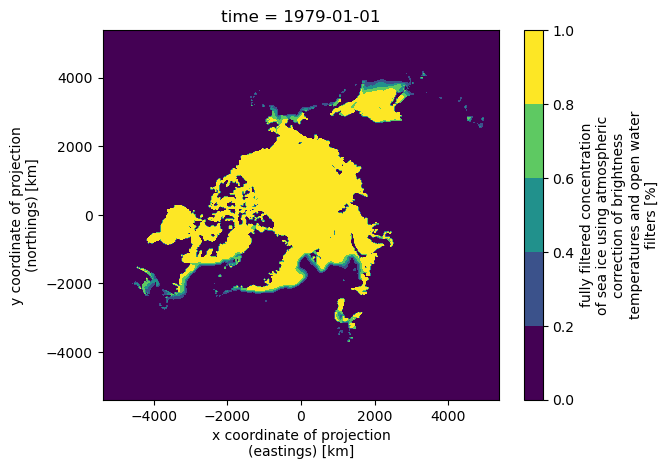

In [15]:
xr.plot.contourf(siconca.isel(time=0))

### 3. Download ERA5 data
The original IceNet paper used a variety of monthly-averaged ERA5 variables as predictors of future sea ice concentration. 

These are listed on [page 3 of the supplementary materials for the original IceNet paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-021-25257-4/MediaObjects/41467_2021_25257_MOESM1_ESM.pdf#page=3) and include
- 2-metre air temperature anomaly (`tas`)
- Sea surface temperature anomaly (`tos`)
- 500 hPa air temperature anomaly (`ta500`)
- Upwelling/downwelling surface solar radiation (`rsds_and_rsus`)
- Sea level pressure anomaly (`psl`)
- 500 hPa geopotential height anomaly (`zg500`)
- 250 hPa geopotential height anomaly (`zg250`)
- 10 hPa zonal wind speed (`ua10`)
- 10-metre u-component of wind (`uas`)
- 10-metre v-component of wind (`vas`)

While a variety of lag times are considered at prediction-time, we need not worry about lag times at download-time, seeing as lagged data is obtained by recursively reusing data.

Using our `icenet-gan` environment, let's download monthly-averaged variables from ERA5 over the time period of 1979-2020 using `src/download_era5_data.py`.

In [2]:
# download era5 data
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/download_era5_data.py
src.download_era5_data()

/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:49:15,713 INFO Welcome to the CDS
2023-06-23 21:49:15,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-06-23 21:49:15,952 INFO Request is completed
2023-06-23 21:49:15,954 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data4/adaptor.mars.internal-1687529007.0209906-14514-15-1b5499c0-9720-4beb-8106-f10f88bd51ba.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/tas_latlon.nc (511.6M)
2023-06-23 21:50:18,836 INFO Download rate 8.1M/s  


Done in 63.437s.

Regridding and saving tas reanalysis data... Done in 10.843s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:50:30,217 INFO Request is completed
2023-06-23 21:50:30,218 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data3/adaptor.mars.internal-1687528395.3097045-13729-4-d7b41867-1a27-46cb-9ae5-7331557e624d.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/tos_latlon.nc (511.6M)
2023-06-23 21:53:33,052 INFO Download rate 2.8M/s  


Done in 183.335s.

Regridding and saving tos reanalysis data... Done in 13.057s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:53:46,905 INFO Request is completed
2023-06-23 21:53:46,906 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data1/adaptor.mars.internal-1687528067.6426542-15311-19-4928e5ff-10e1-4545-916c-c935938fe62b.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/ta500_latlon.nc (511.6M)
2023-06-23 21:54:35,957 INFO Download rate 10.4M/s 


Done in 49.320s.

Regridding and saving ta500 reanalysis data... Done in 9.819s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:54:46,237 INFO Request is completed
2023-06-23 21:54:46,238 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data3/adaptor.mars.internal-1687527550.1585536-20902-7-a624079d-5799-4eba-b13f-43ad91985415.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/rss_latlon.nc (511.6M)
2023-06-23 21:55:28,715 INFO Download rate 12M/s   
2023-06-23 21:55:28,878 INFO Welcome to the CDS
2023-06-23 21:55:28,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means


Done in 42.725s.




2023-06-23 21:55:29,067 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/adaptor.mars.internal-1687529174.939801-9945-12-ef7df549-8510-4d6e-9c56-e1ed2e125ade.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/rsds_latlon.nc (511.6M)
2023-06-23 21:56:04,762 INFO Download rate 14.3M/s 


Done in 35.965s.

Regridding and saving rsus reanalysis data... Done in 7.673s.

Regridding and saving rsds reanalysis data... Done in 8.492s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:56:38,392 INFO Request is completed
2023-06-23 21:56:38,393 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data3/adaptor.mars.internal-1687527732.984491-20323-3-d436e5fe-45d9-45b4-a71d-3a9c1c7ff962.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/psl_latlon.nc (511.6M)
2023-06-23 21:57:14,266 INFO Download rate 14.3M/s 


Done in 36.182s.

Regridding and saving psl reanalysis data... Done in 11.017s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:57:25,794 INFO Request is completed
2023-06-23 21:57:25,796 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data9/adaptor.mars.internal-1687528715.0953674-26160-2-8991032b-2607-4d7e-9d19-f11813b3474c.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/zg500_latlon.nc (511.6M)
2023-06-23 21:58:02,716 INFO Download rate 13.9M/s 


Done in 37.195s.

Regridding and saving zg500 reanalysis data... Done in 10.899s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:59:03,236 INFO Download rate 10.4M/s 


Done in 49.383s.

Regridding and saving zg250 reanalysis data... Done in 11.399s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 21:59:15,168 INFO Request is completed
2023-06-23 21:59:15,169 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data0/adaptor.mars.internal-1687527900.7088199-11038-17-f523def1-cda4-4d3b-a1e9-efeb0b66f64f.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/ua10_latlon.nc (511.6M)
2023-06-23 22:00:07,555 INFO Download rate 9.8M/s  


Done in 52.662s.

Regridding and saving ua10 reanalysis data... Done in 11.030s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 22:00:19,106 INFO Request is completed
2023-06-23 22:00:19,107 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data4/adaptor.mars.internal-1687528863.6644626-4409-8-5e5d593d-edd5-45e6-8300-1f5faf67257d.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/uas_latlon.nc (511.6M)
2023-06-23 22:01:15,003 INFO Download rate 9.2M/s  


Done in 56.213s.

Regridding and saving uas reanalysis data... Done in 11.199s.


/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/download_era5_data.py:168: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic

2023-06-23 22:01:26,681 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1687528549.6942043-12633-11-84e1a177-fd19-4279-9334-b685cdaefafd.nc to /data/hpcdata/users/anddon76/icenet-gan-data/obs/vas_latlon.nc (511.6M)
2023-06-23 22:02:18,855 INFO Download rate 9.8M/s  


Done in 52.422s.

Regridding and saving vas reanalysis data... Done in 10.007s.


Let's see what this ERA5 data looks like. We'll hold off on visualising the surface wind variables for the moment, as those are subject to further processing in the next step of the notebook.

In [5]:
os.listdir(src.obs_data_folder)

['siconca_EASE.nc',
 '.listing',
 'ice_conc_nh_ease2-250_cdr-v2p0_197901021200.nc',
 'tas_EASE.nc',
 'tos_EASE.nc',
 'ta500_EASE.nc',
 'rsus_EASE.nc',
 'rsds_EASE.nc',
 'psl_EASE.nc',
 'zg500_EASE.nc',
 'zg250_EASE.nc',
 'ua10_EASE.nc',
 'uas_EASE.nc',
 'vas_EASE.nc']

In [10]:
tas = xr.open_dataset(src.obs_data_folder + "/tas_EASE.nc").t2m
tas

<xarray.DataArray 't2m' (time: 516, yc: 432, xc: 432)>
[96297984 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * yc       (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * xc       (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
Attributes:
    long_name:     2 metre temperature
    units:         K
    grid_mapping:  lambert_azimuthal_equal_area

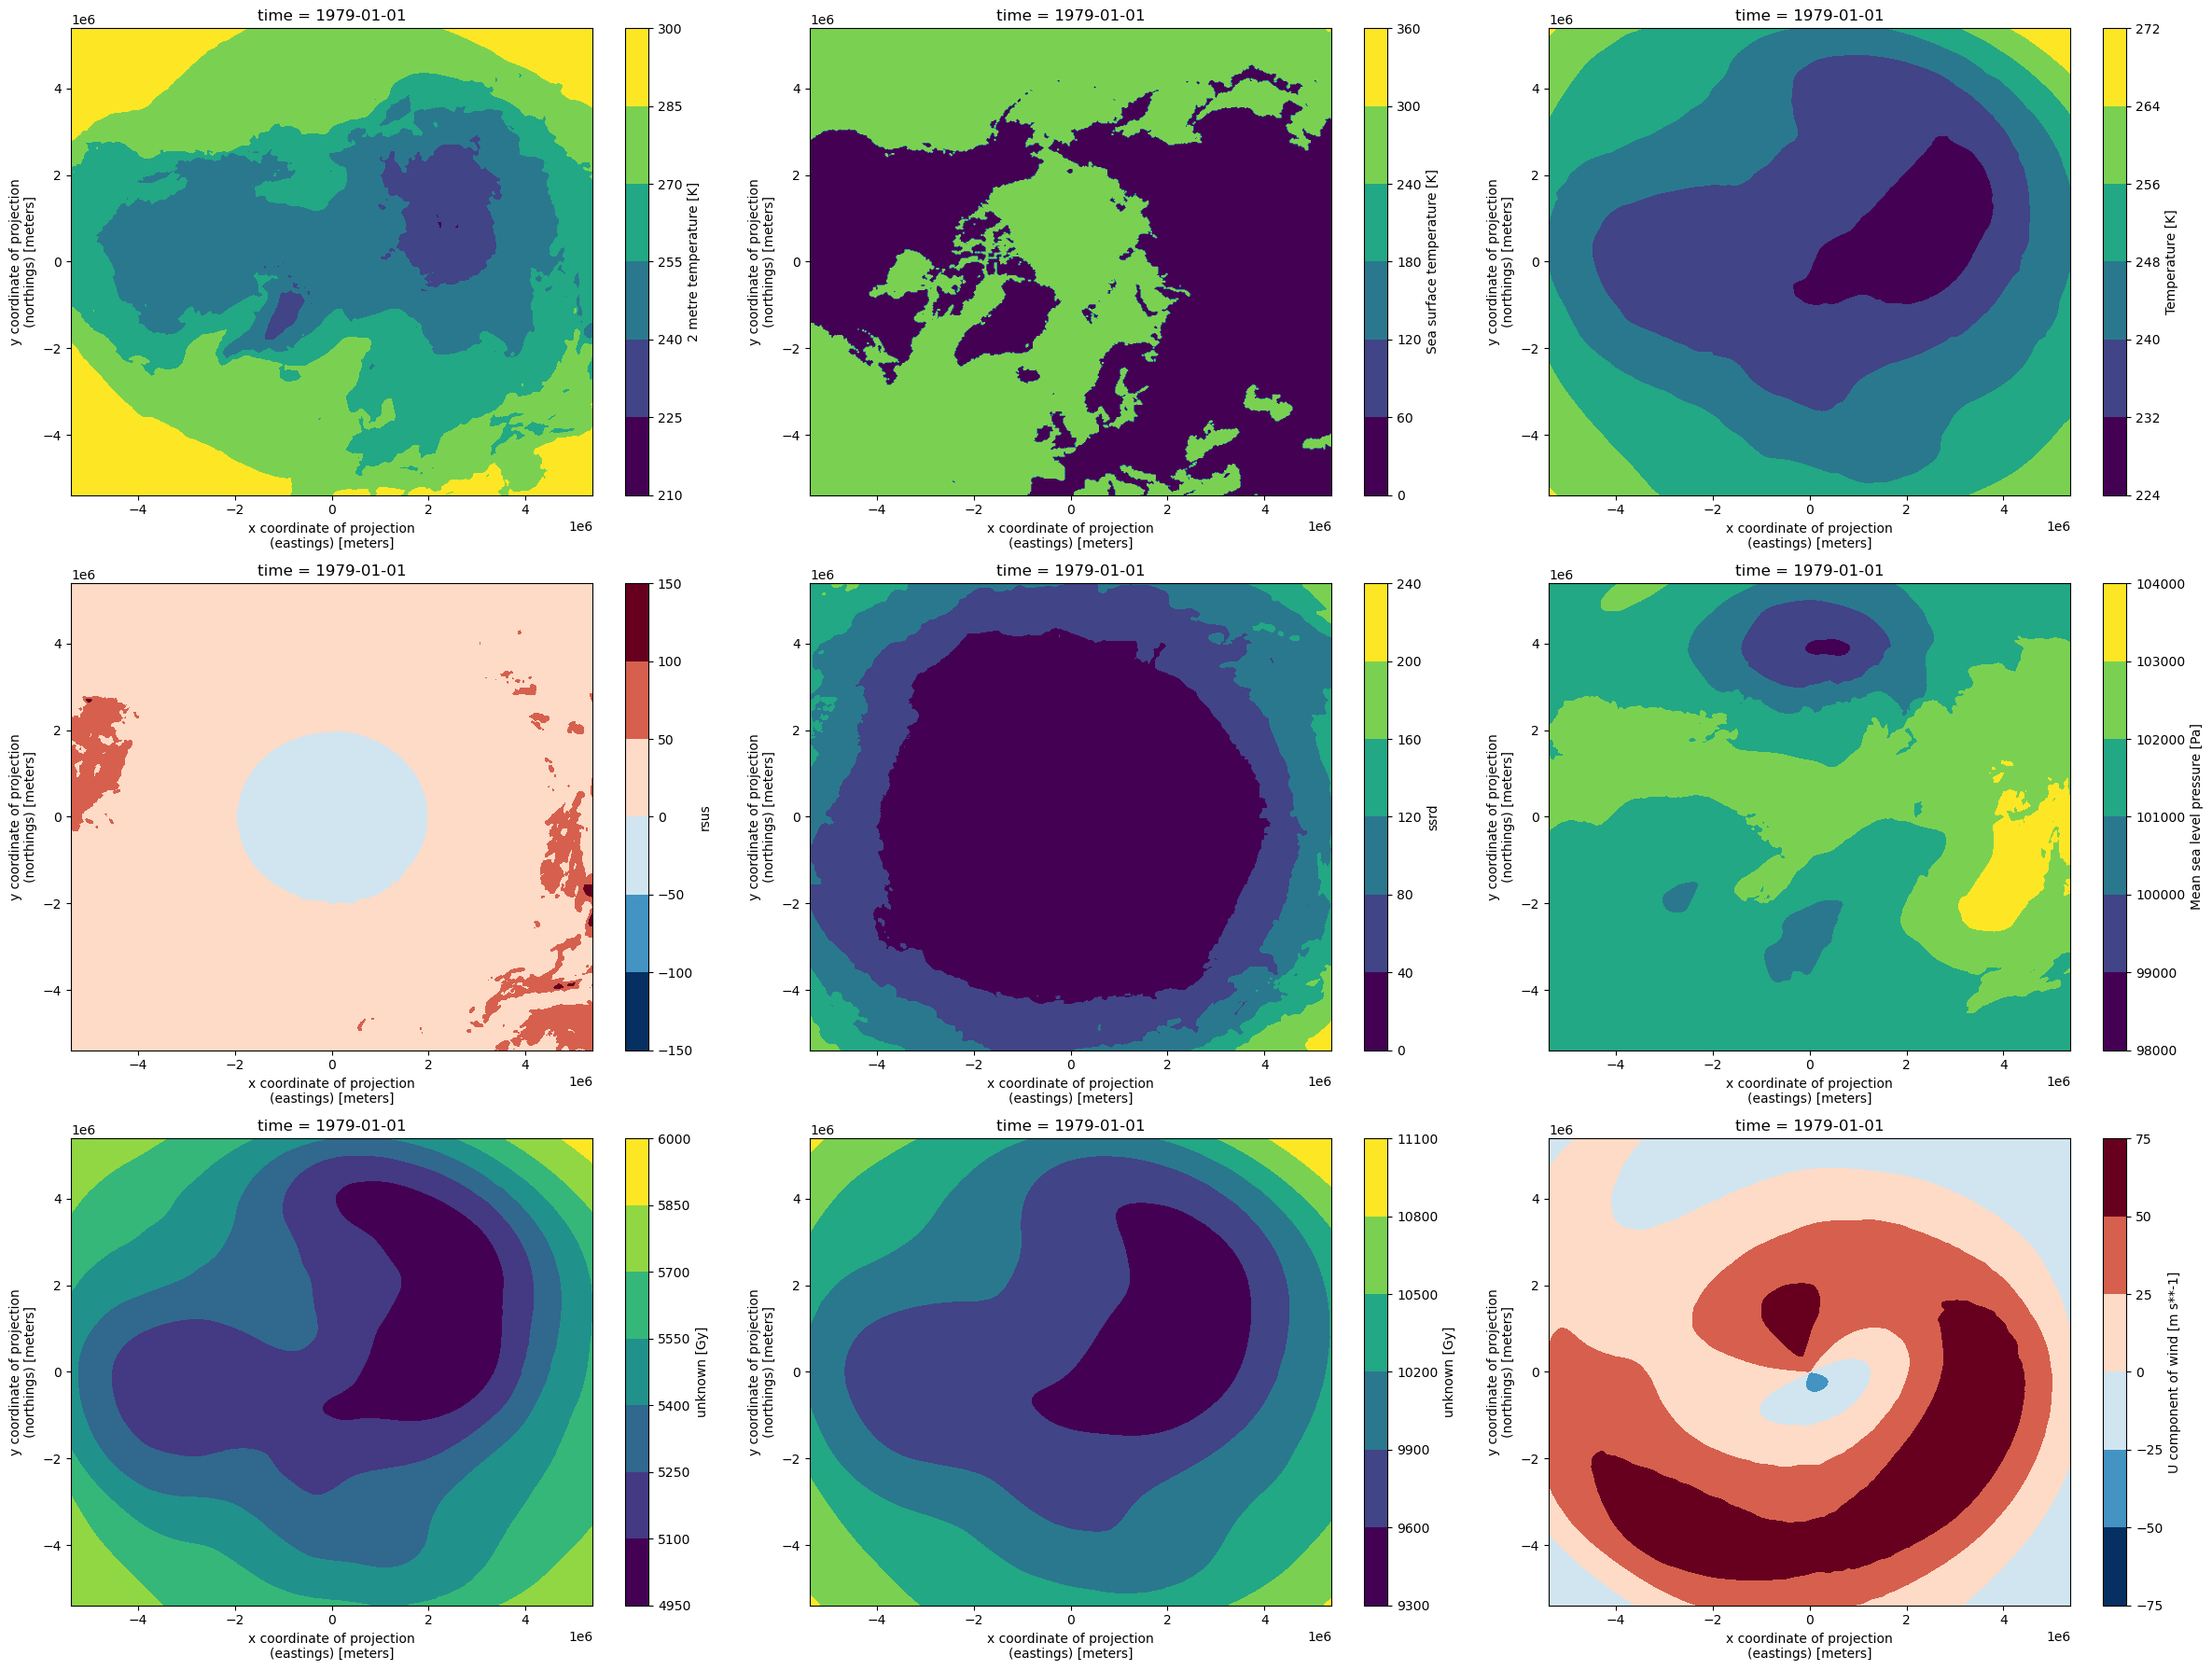

In [25]:
era5 = [
    xr.open_dataset(src.obs_data_folder + "/tas_EASE.nc").t2m,
    xr.open_dataset(src.obs_data_folder + "/tos_EASE.nc").sst,
    xr.open_dataset(src.obs_data_folder + "/ta500_EASE.nc").t,
    xr.open_dataset(src.obs_data_folder + "/rsus_EASE.nc").rsus,
    xr.open_dataset(src.obs_data_folder + "/rsds_EASE.nc").ssrd,
    xr.open_dataset(src.obs_data_folder + "/psl_EASE.nc").msl,
    xr.open_dataset(src.obs_data_folder + "/zg500_EASE.nc").unknown,
    xr.open_dataset(src.obs_data_folder + "/zg250_EASE.nc").unknown,
    xr.open_dataset(src.obs_data_folder + "/ua10_EASE.nc").u
]
fig, ax = plt.subplots(3, 3, figsize=(24, 18))
ax = ax.ravel()
for i in range(9):
    xr.plot.contourf(era5[i].isel(time=0), ax=ax[i])
plt.tight_layout()
plt.show()

### 4. Rotate wind data

IceNet utilises the [EASE (Equal-Area Scalable Earth) grid](https://nsidc.org/data/user-resources/help-center/guide-ease-grids) projection to minimise distortion in the polar regions and to weight equal areas equally when computing loss functions and performance metrics.

The scripts we used to download sea ice concentration and ERA5 data handled the initial reprojection of each variable but further processing is needed to correct the wind fields obtained from ERA5.

Using our `icenet-gan` environment, let's rotate these wind fields to align with the EASE grid using `src/rotate_wind_data.py`.


In [2]:
# rotate wind data in era5
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/rotate_wind_data.py
src.rotate_wind_data()

/users/anddon76/icenet/icenet-gan/src/rotate_wind_data.py:59: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/rotate_wind_data.py:59: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cube = iris.load_cube(sic_day_fpath, 'sea_ice_area_fraction')
/users/anddon76/icenet/icenet-gan/src/rotate_wind_data.py:59: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  sic_EASE_cub


Rotating wind data in /data/hpcdata/users/anddon76/icenet-gan-data/obs


/users/anddon76/icenet/icenet-gan/src/rotate_wind_data.py:82: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  wind_cubes[var] = iris.load_cube(EASE_path)
/users/anddon76/icenet/icenet-gan/src/rotate_wind_data.py:82: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  wind_cubes[var] = iris.load_cube(EASE_path)


Skipping due to existing file: /data/hpcdata/users/anddon76/icenet-gan-data/obs/uas_EASE.nc
Skipping due to existing file: /data/hpcdata/users/anddon76/icenet-gan-data/obs/vas_EASE.nc
generating video for uas


100%|██████████| 516/516 [00:36<00:00, 14.29it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


generating video for vas


100%|██████████| 516/516 [00:36<00:00, 14.05it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done in 243.507s.


Let's see what this wind data looks like.

In [24]:
os.listdir(src.obs_data_folder)

['siconca_EASE.nc',
 '.listing',
 'ice_conc_nh_ease2-250_cdr-v2p0_197901021200.nc',
 'tas_EASE.nc',
 'tos_EASE.nc',
 'ta500_EASE.nc',
 'rsus_EASE.nc',
 'rsds_EASE.nc',
 'psl_EASE.nc',
 'zg500_EASE.nc',
 'zg250_EASE.nc',
 'ua10_EASE.nc',
 'uas_EASE.nc',
 'vas_EASE.nc']

In [6]:
uas = xr.open_dataset(src.obs_data_folder + "/uas_EASE.nc").u10
uas

<xarray.DataArray 'u10' (time: 516, yc: 432, xc: 432)>
[96297984 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * yc       (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * xc       (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
Attributes:
    long_name:     10 metre U wind component
    units:         m s**-1
    grid_mapping:  lambert_azimuthal_equal_area

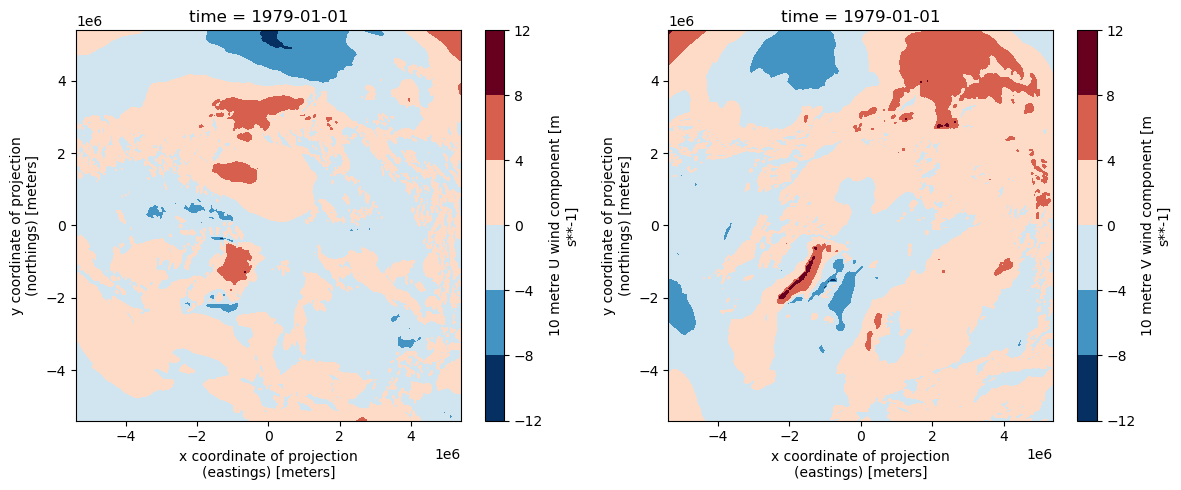

In [31]:
wind = [
    xr.open_dataset(src.obs_data_folder + "/uas_EASE.nc").u10,
    xr.open_dataset(src.obs_data_folder + "/vas_EASE.nc").v10
]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    xr.plot.contourf(wind[i].isel(time=0), ax=ax[i])
plt.tight_layout()
plt.show()

### 5. Download SEAS5 baseline
We'll compare the performance of our data-driven forecasting models against the operational [SEAS5 dynamical model](https://doi.org/10.5194/gmd-12-1087-2019) maintained by ECMWF.

Using our `icenet-gan` environment, let's obtain these archived SEAS5 sea ice forecasts using `src/download_seas5_forecasts.py`.

In [ ]:
# download seas5 forecasts
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/download_seas5_forecasts.py
# note: this cell should work but was not run as data was copied locally from BAS HPC in our case
src.download_seas5_forecasts()

Let's see what this SEAS5 forecast data looks like.

In [42]:
os.listdir(src.config.forecast_data_folder + "/seas5/EASE")

['seas5_leadtime1_EASE.nc',
 'seas5_leadtime2_EASE.nc',
 'seas5_leadtime3_EASE.nc',
 'seas5_leadtime5_EASE.nc',
 'seas5_leadtime4_EASE.nc',
 'seas5_leadtime6_EASE.nc']

In [43]:
seas5 = xr.open_dataset(src.forecast_data_folder + "/seas5/EASE/seas5_leadtime1_EASE.nc").siconc
seas5

<xarray.DataArray 'siconc' (time: 228, number: 25, yc: 432, xc: 432)>
[1063756800 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2020-12-01
  * number   (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * yc       (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * xc       (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
Attributes:
    standard_name:  sea_ice_area_fraction
    long_name:      Sea ice area fraction
    grid_mapping:   lambert_azimuthal_equal_area

Note that the `number` field ranging from 0-24 indexes the SEAS5 forecast ensemble members. Hence the dimensionality of the SEAS5 data for a single timestep is a cube of shape `(25, 432, 432)`, where each slice `[i, :, :]` represents the forecast from a single ensemble member.

Let's visualise a few of these ensemble members below.

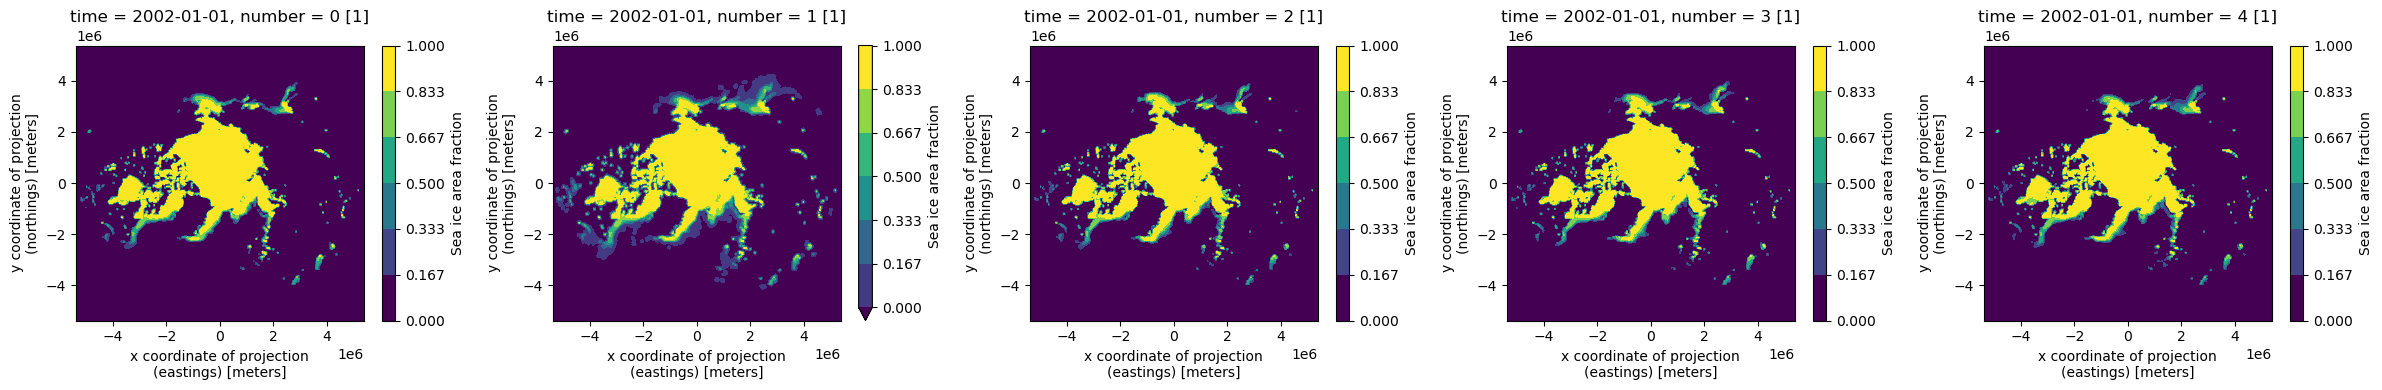

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(24, 4))
for i in range(5):
    xr.plot.contourf(seas5.isel(time=0, number=i), ax=ax[i], vmin=0)
plt.tight_layout()
plt.show()

Now, let's visualise the ensemble's mean and standard deviation to characterise its distribution.

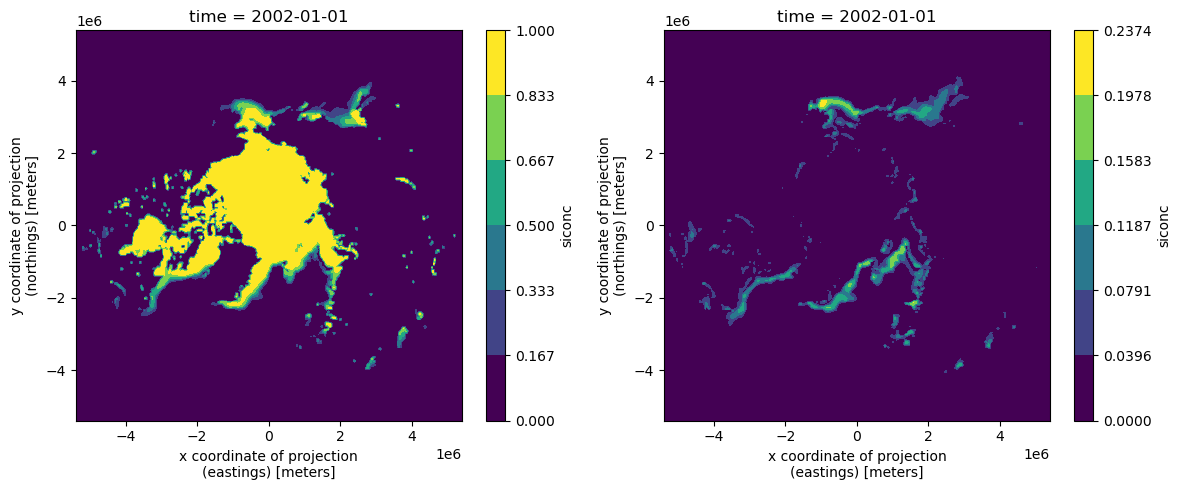

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
xr.plot.contourf(seas5.isel(time=0).mean(dim="number"), ax=ax[0], vmin=0)
xr.plot.contourf(seas5.isel(time=0).std(dim="number"), ax=ax[1], vmin=0)
plt.tight_layout()
plt.show()

### 6. Bias correct SEAS5 outputs
Before we're able to use the SEAS5 outputs as a point of comparison, we need to bias-correct them against the observed sea ice concentration data from OSI-SAF.

We also need to compute sea ice probability values from the SEAS5 forecasts.

Using our `icenet-gan` environment, let's bias-correct these SEAS5 sea ice forecasts using `src/biascorrect_seas5_forecasts.py`.

In [ ]:
# download seas5 forecasts
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/biascorrect_seas5_forecasts.py
# note: this cell should work but was not run as data was copied locally from BAS HPC in our case
src.biascorrect_seas5_forecasts()

Let's see what the bias-corrected forecasts look like.

In [46]:
os.listdir(src.config.forecast_data_folder + "/seas5")

['latlon', 'EASE', 'seas5_forecasts.nc', 'seas5_sip_forecasts.nc']

In [53]:
seas5_bc = xr.open_dataarray(src.forecast_data_folder + "/seas5/seas5_forecasts.nc")
seas5_bc

<xarray.DataArray (leadtime: 6, time: 233, yc: 432, xc: 432)>
[260900352 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2021-05-01
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * leadtime  (leadtime) int64 1 2 3 4 5 6
    lat       (yc, xc) float32 ...
    lon       (yc, xc) float32 ...

Note that the `leadtime` field ranging from 1-6 indexes the number of months ahead for which the SEAS5 forecast was generated forecast ensemble members. Hence the dimensionality of the bias-corrected SEAS5 data for a single timestep is a cube of shape `(432, 432, 6)`, where each slice `[:, :, i]` represents the ensemble mean forecast for a leadtime of `i` months from the forecast date.

Let's visualise one of these ensemble mean forecasts at leadtimes of 1 to 6 months below.

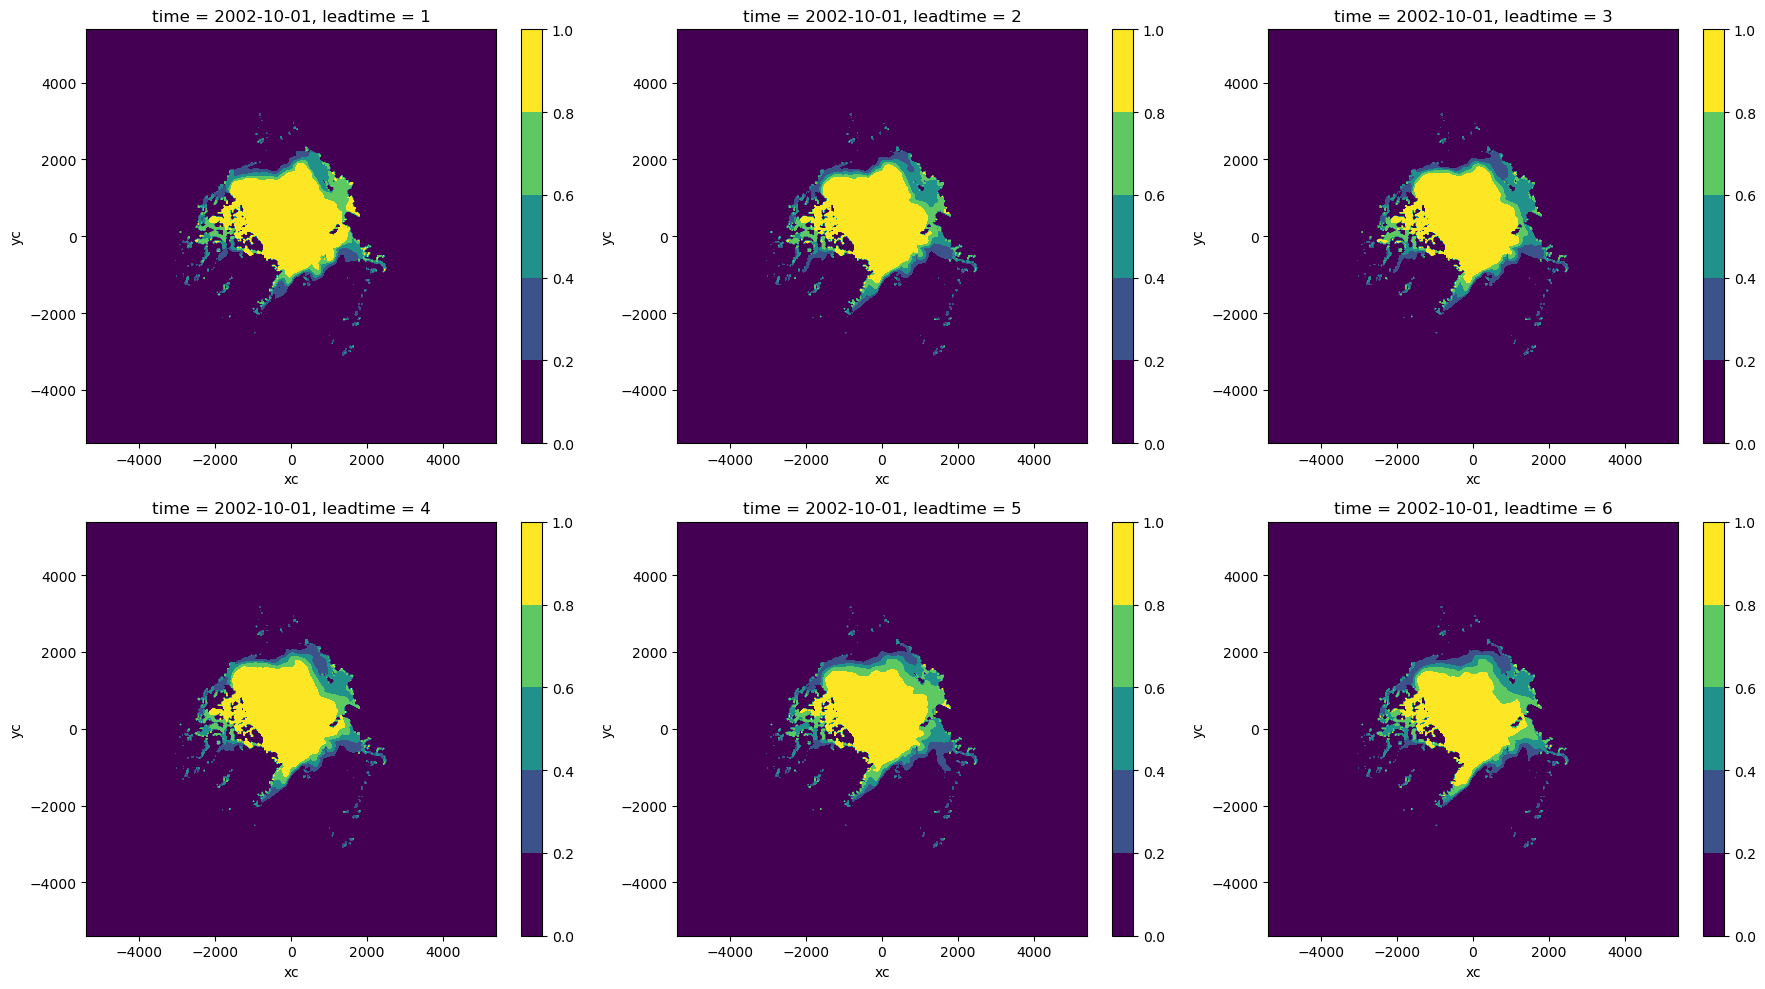

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
ax = ax.ravel()
for i in range(6):
    xr.plot.contourf(seas5_bc.isel(time=9, leadtime=i), ax=ax[i])
plt.tight_layout()
plt.show()

### 7. Configure dataloader
At this stage, we begin to deviate a bit from the original IceNet implementation.

The principle of organisation remains the same—we proceed to configure our dataloader—but we use PyTorch whereas the original codebase used Tensorflow.

Let's generate our data loader configuration file using `src/gen_data_loader_config.py` with our `icenet-gan` environment.

In [2]:
# generate data loader configuration file
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/gen_data_loader_config.py
src.gen_data_loader_config()

Data loader config saved to /users/anddon76/icenet/icenet-gan/dataloader_configs/2023_06_24_1235_icenet_gan.json

Data loader name: 2023_06_24_1235_icenet_gan


### 8. Preprocess data
Now that our dataloader is configured, we'll normalise our netCDF data and save it as `.npy` files to speed up training.

Let's use `src/preproc_icenet_data.py` with our `icenet-gan` environment.

In [2]:
# preprocess data into npy files
# based on https://github.com/tom-andersson/icenet-paper/blob/main/icenet/preproc_icenet_data.py
src.preproc_icenet_data()

Setting up the folder hierarchy for dataset_no_cmip... Done.
Loading and normalising the raw input maps.

Preprocessing abs data for siconca...  

Saving abs siconca monthly averages... Done.
Done in 5s.

Preprocessing linear_trend data for siconca...  Saving linear_trend siconca monthly averages... Done.
Done in 42s.

Preprocessing anom data for tas...  Newly computed mean/std: -1.4841067157833734e-12/1.980050766047356...  Saving anom tas monthly averages... Done.
Done in 13s.

Preprocessing anom data for ta500...  Newly computed mean/std: -2.1626267985101494e-12/1.6591156546695036...  Saving anom ta500 monthly averages... Done.
Done in 15s.

Preprocessing anom data for tos...  Newly computed mean/std: 5.831939673377076e-13/0.5280959857820127...  Saving anom tos monthly averages... Done.
Done in 8s.

Preprocessing anom data for rsds...  Newly computed mean/std: -3.148543553706631e-11/11.750221444187039...  Saving anom rsds monthly averages... Done.
Done in 14s.

Preprocessing anom data for rsus...  Newly computed mean/std: 9.813559443232346e-13/7.24904892587762...  Saving anom rsus monthly averages... Done.
Done in 14s.

Preproc

### 9. Verify dataloading process
To confirm that our implementation of the `IceNetDataset` class in `src/utils.py` works as expected after translating from `tensorflow` to `torch`, let's construct and load a few batches of data.

Note that the dates associated with our `train_dataset`, `val_dataset`, and `test_dataset` are different for each dataloader and correspond to our dataloader configuration JSON file.

In [2]:
dataloader_config_fpath = os.path.join(src.dataloader_config_folder, "2023_06_24_1235_icenet_gan.json")
train_dataset = src.IceNetDataset(dataloader_config_fpath, mode="train")
print(len(train_dataset))
train_dataset.obs_forecast_IDs

Setting the data generator's random seed to 42
Checking forecast start dates for missing SIC dates... 

Setting up the variable paths for dataset_no_cmip... Done.
Setting the number of input months for each input variable.
Loading and augmenting the polar holes... Done in 0s.

on_epoch_end called
Setup complete.

377


[Timestamp('1980-02-01 00:00:00'),
 Timestamp('1980-03-01 00:00:00'),
 Timestamp('1980-04-01 00:00:00'),
 Timestamp('1980-05-01 00:00:00'),
 Timestamp('1980-06-01 00:00:00'),
 Timestamp('1980-07-01 00:00:00'),
 Timestamp('1980-08-01 00:00:00'),
 Timestamp('1980-09-01 00:00:00'),
 Timestamp('1980-10-01 00:00:00'),
 Timestamp('1980-11-01 00:00:00'),
 Timestamp('1980-12-01 00:00:00'),
 Timestamp('1981-01-01 00:00:00'),
 Timestamp('1981-02-01 00:00:00'),
 Timestamp('1981-03-01 00:00:00'),
 Timestamp('1981-04-01 00:00:00'),
 Timestamp('1981-05-01 00:00:00'),
 Timestamp('1981-06-01 00:00:00'),
 Timestamp('1981-07-01 00:00:00'),
 Timestamp('1981-08-01 00:00:00'),
 Timestamp('1981-09-01 00:00:00'),
 Timestamp('1981-10-01 00:00:00'),
 Timestamp('1981-11-01 00:00:00'),
 Timestamp('1981-12-01 00:00:00'),
 Timestamp('1982-01-01 00:00:00'),
 Timestamp('1982-02-01 00:00:00'),
 Timestamp('1982-03-01 00:00:00'),
 Timestamp('1982-04-01 00:00:00'),
 Timestamp('1982-05-01 00:00:00'),
 Timestamp('1982-06-

In [3]:
val_dataset = src.IceNetDataset(dataloader_config_fpath, mode="val")
print(len(val_dataset))
val_dataset.obs_forecast_IDs

Setting the data generator's random seed to 42
Checking forecast start dates for missing SIC dates... Setting up the variable paths for dataset_no_cmip... Done.
Setting the number of input months for each input variable.
Loading and augmenting the polar holes... Done in 0s.

on_epoch_end called
Setup complete.

65


[Timestamp('2012-02-01 00:00:00'),
 Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-04-01 00:00:00'),
 Timestamp('2012-05-01 00:00:00'),
 Timestamp('2012-06-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2012-08-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2012-10-01 00:00:00'),
 Timestamp('2012-11-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2013-02-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-08-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'),
 Timestamp('2013-10-01 00:00:00'),
 Timestamp('2013-11-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-04-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2014-06-

In [4]:
test_dataset = src.IceNetDataset(dataloader_config_fpath, mode="test")
print(len(test_dataset))
test_dataset.obs_forecast_IDs

Setting the data generator's random seed to 42
Checking forecast start dates for missing SIC dates... Setting up the variable paths for dataset_no_cmip... Done.
Setting the number of input months for each input variable.
Loading and augmenting the polar holes... Done in 0s.

on_epoch_end called
Setup complete.

17


[Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00')]

In [3]:
print(train_dataset.all_forecast_IDs[0])
X, y, sample_weight = train_dataset[0]
X.shape, y.shape, sample_weight.shape

2011-05-01 00:00:00


((432, 432, 50), (432, 432, 3, 6), (432, 432, 1, 6))

Nifty! Let's unpack what this last chunk means.
- `X`, an individual input tensor, has a shape of 432x432 with 50 channels of meteorological predictors
- `y`, an individual target tensor, has a shape of 432x432 with 3 target channels, namely `SIC < 15%` (ice-free), `15% ≤ SIC ≤ 85%` (marginal ice), and `SIC > 85%` (full ice), at 6 leadtimes for the 6 months following the input conditions
- `sample_weight`, a loss weighting tensor, has a shape of 432x432 with 1 channel of pixel weights at 6 leadtimes for the 6 months following the input conditions

These tensors correspond to forecast ID 0, which (after shuffling) happens to correspond to the forecast with predictors in May 2011 and targets in June-November 2011.

Let's visualise these tensors.

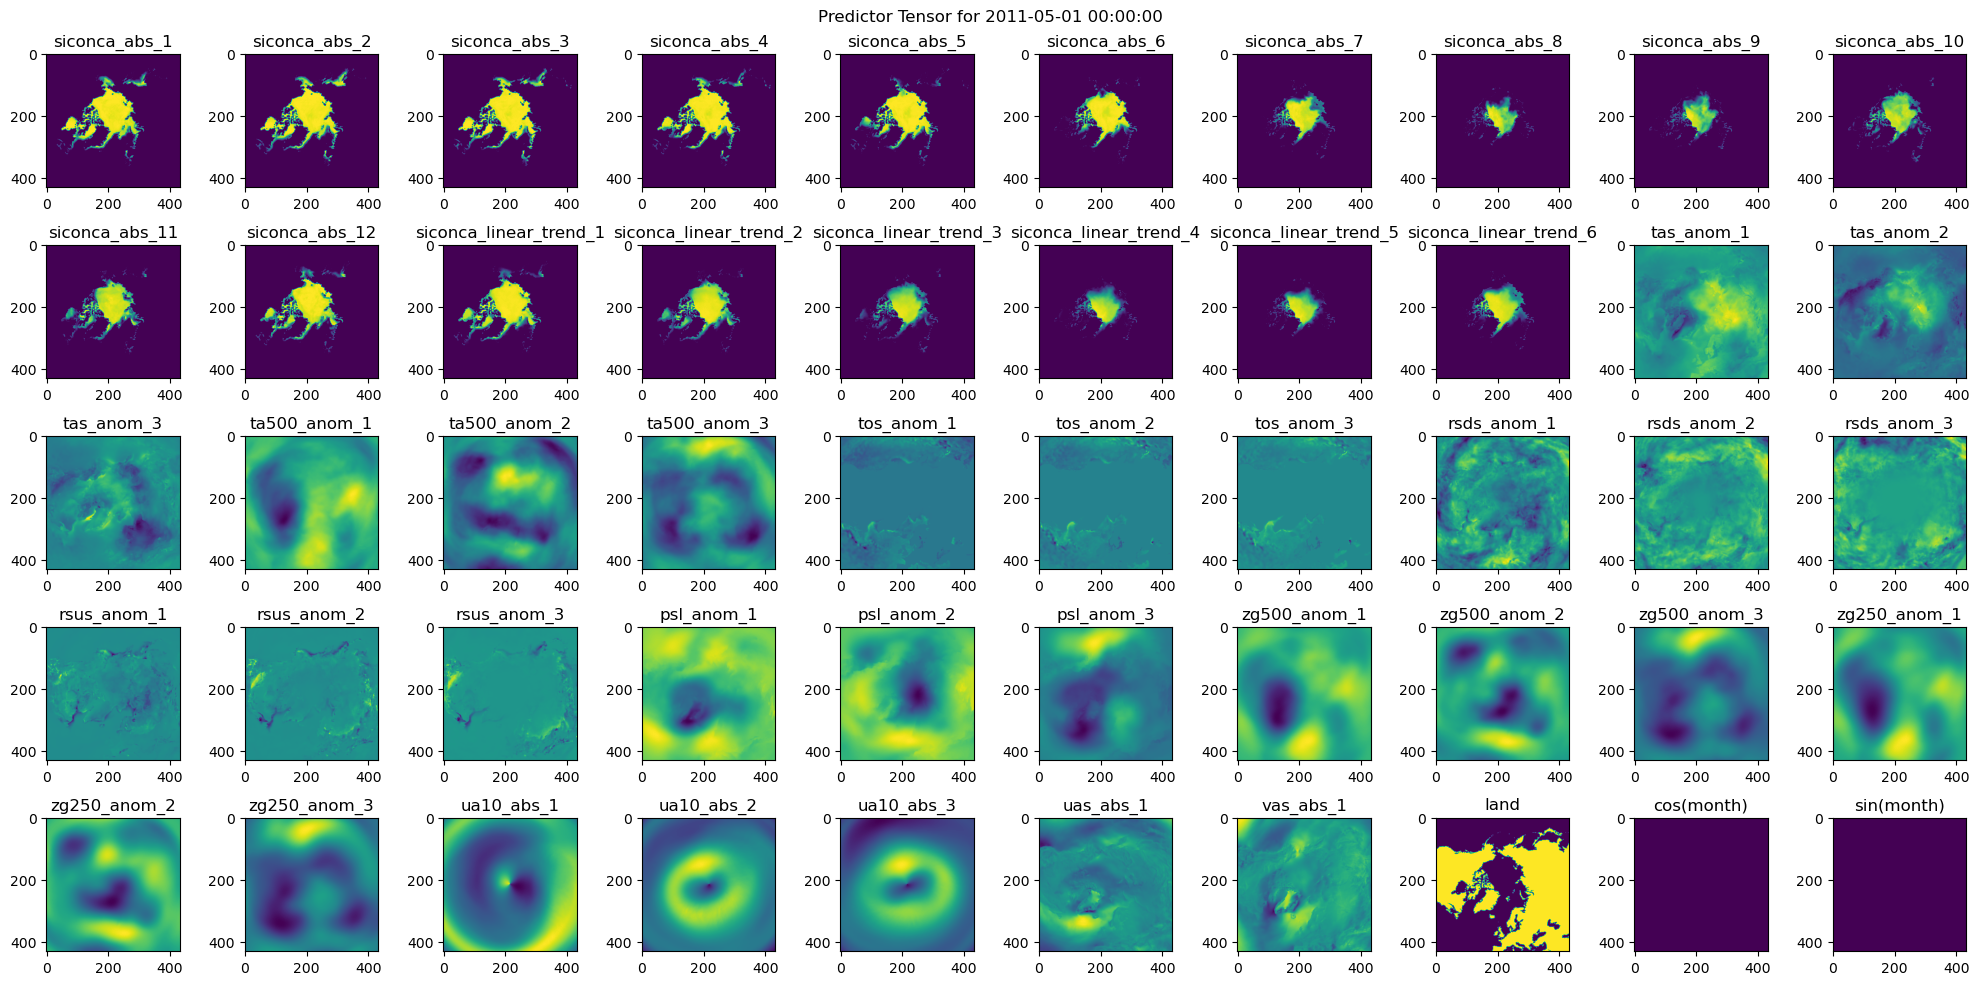

In [24]:
# note that the numbers associated to observational data are lags and
# the numbers associated to trend data are leads in the predictor tensor
X_variables = train_dataset.determine_variable_names()
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
ax = ax.ravel()
for i in range(50):
    ax[i].imshow(X[:, :, i])
    ax[i].set_title(X_variables[i])
plt.suptitle(f"Predictor Tensor for {train_dataset.all_forecast_IDs[0]}")
plt.tight_layout()
plt.show()

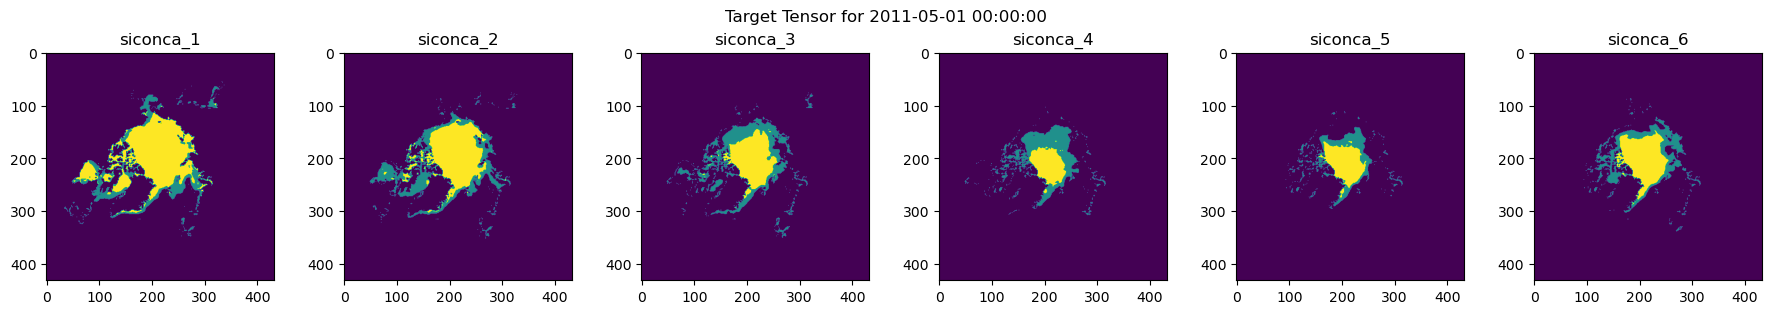

In [29]:
# note that the numbers associated to observational data are now
# leads, not lags, in the target tensor
y_variables = [f"siconca_{i}" for i in range(1, 7)]
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
for i in range(6):
    ax[i].imshow(y.argmax(axis=2)[:, :, i])
    ax[i].set_title(y_variables[i])
plt.suptitle(f"Target Tensor for {train_dataset.all_forecast_IDs[0]}")
plt.tight_layout()
plt.show()

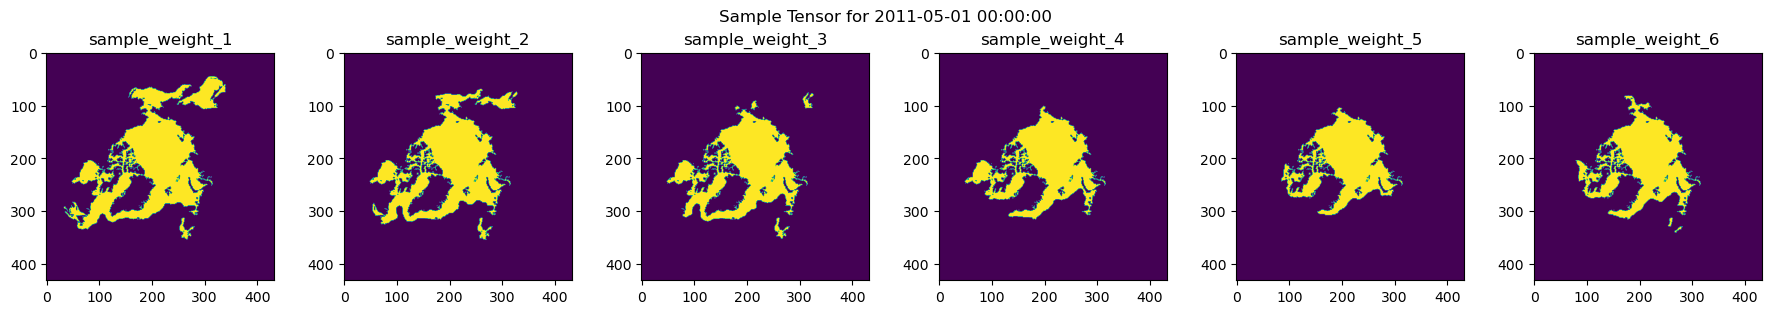

In [30]:
# note that the numbers associated to sample weights are leads 
# and correspond to the leads of the target tensor
w_variables = [f"sample_weight_{i}" for i in range(1, 7)]
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
for i in range(6):
    ax[i].imshow(sample_weight.squeeze(axis=2)[:, :, i])
    ax[i].set_title(w_variables[i])
plt.suptitle(f"Sample Tensor for {train_dataset.all_forecast_IDs[0]}")
plt.tight_layout()
plt.show()

It may look like this sample weight tensor is simply a binary mask. But, alas, it is not! It's weighted according to the amount of each pixel covered by ice.

This will be important to remember later on.

Let's visualise the distribution of pixel values in the weight tensor.

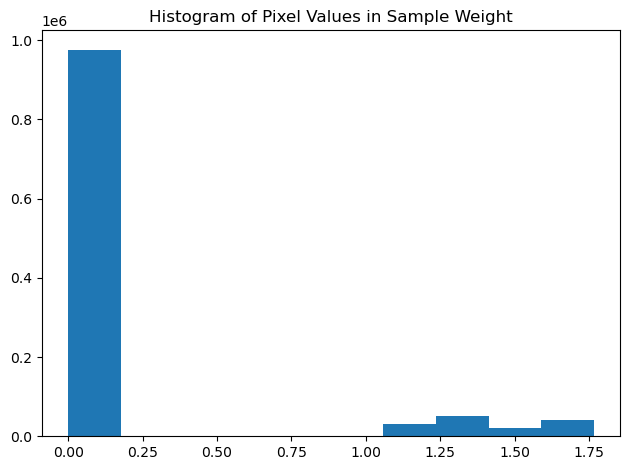

In [5]:
plt.hist(sample_weight.ravel())
plt.title("Histogram of Pixel Values in Sample Weight")
plt.tight_layout()
plt.show()

### 10. All set
Our data is ready to rock and roll!

We'll continue by training models in the next notebook.